In [29]:
# %%writefile Ind_WPR_OSC.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)

import Ind_Model_Base

import numpy as np
import pandas as pd

import QUANTAXIS as QA

# import matplotlib.pyplot as plt


import Analysis_Funs as af

import talib
import base.JuUnits as ju

# %load_ext autoreload
# %autoreload 2
# %aimport Analysis_Funs,Ind_Model_Base


class WPR(Ind_Model_Base.Ind_Model):
    """ 威廉姆斯百分比范围 Williams %R (Williams' Percent Range)
        超买超卖指示
    """
    optimum_param={'valid':False, 'main':'WPR', 'desition_direct':1, 'freq':'d','neutralize':{'enable':False,'static_mv':False}}
    
    def __init__(self,data, frequence=QA.FREQUENCE.DAY):
        super().__init__(data, 'WPR', frequence)
        
        ### 正式使用时由实例设置为true来加速
#         self.set_ignore_sub_ind(False)
        

    def on_set_params_default(self):
        return {'timeperiod':14}
    
        
    def on_indicator_structuring(self, data):
        return self.excute_for_multicode(data, self.kernel, **self.pramas)
    
    def on_desition_structuring(self, data, ind_data):
        """
        """
        def feature(item_df):
            direct = np.sign(item_df['WPR'] - item_df['WPRMA'])
#             return -1 * np.abs( af.timeline_event_continuity(direct.fillna(0)) )
            return af.timeline_event_continuity(direct.fillna(0))

        event_continuity = self.excute_for_multicode(self.ind_df,
                                         lambda x: pd.DataFrame(feature(x),
                                         index=x.index,
                                         columns=['feature_WPR_CONTINUITY_NEG_ABS']))
        # NEG_ABS时防止0干扰
#         event_continuity[event_continuity==0] = np.nan
        self.ind_df = pd.concat([self.ind_df, event_continuity],axis=1)
        return None #event_continuity
        
    def kernel(self,dataframe, timeperiod):
#        %R = -     (   MAX(HIGH (i - n)) - CLOSE (i)   ) /       (MAX (HIGH (i - n)) - MIN (LOW (i - n)))                   * 100 
        if len(dataframe)<=timeperiod:
            return None
                
        
        def wpr_base(x):
            x_t = x.T
            low_min = x_t[2].min()
            high_max = x_t[3].max()
            close = x_t[4][-1]
#             print(low_min,high_max,close)
            r = -(high_max - close) / (high_max - low_min) *100
            return r
        
        r = ju.roll_multi_result(dataframe[['low', 'high','close']], wpr_base, timeperiod, 1).T[0]
        r_series = pd.Series(r,index=dataframe.index)
        r_series.name = "WPR"
        try:
            ma = talib.MA(r_series, timeperiod)
        except:
            print(dataframe)
        ma.name = 'WPRMA'
        
        df = pd.concat([r_series,ma], axis=1)
#         df = pd.DataFrame(r_series)
        return df

    def plot(self):
        if self.fast_mode:
            raise 'fast_mode is True,cant draw chart'
        
        


In [25]:
data = smpl.get_data(['000001'],end='2019-11-29',gap=20).data

def wpr_base(x):
    x_t = x.T
    low_min = x_t[2].min()
    high_max = x_t[3].max()
    close = x_t[4][-1]
#     print(low_min,high_max,close)
    r = -(high_max - close) / (high_max - low_min) *100
    return r
tt = ju.roll_multi_result(data[['low', 'high','close']], wpr_base, 2, 1).T[0]

r_s = pd.Series(tt,index=data.index)

print(len(tt),len(data.index))

# %R = -     (   MAX(HIGH (i - n)) - CLOSE (i)   ) /       (MAX (HIGH (i - n)) - MIN (LOW (i - n)))                   * 100 

21 21


Wall time: 466 ms


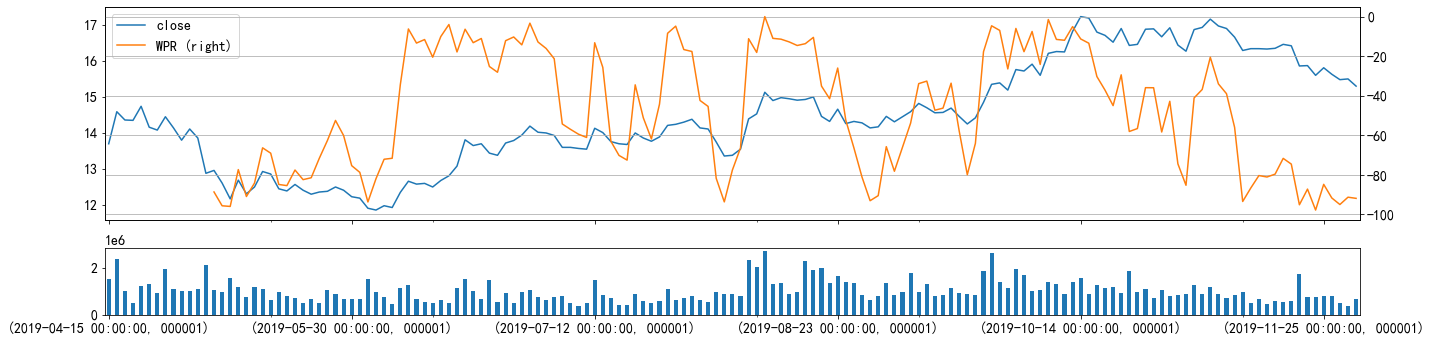

In [19]:
%%time
import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)
import tools.Sample_Tools as smpl
import Analysis_Funs as af
import base.JuUnits as ju
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import talib
data = smpl.get_data(['000001'],end='2019-11-29',gap=154).data

wpr =WPR(data)
wpr.fit()


fig = plt.figure(figsize=(1620/72,620/72))
ax1= fig.add_subplot(2,1,1)
pd.concat([data.close,wpr.ind_df['WPR']],axis=1).plot(secondary_y=['WPR'],ax=ax1)
plt.grid()
ax2= fig.add_subplot(6,1,4,sharex=ax1)
data.volume.plot(kind='bar',ax=ax2)
ax2.tick_params(labelbottom=True)  #  解决share后标签不可见的问题。
ax2.xaxis.set_major_locator(ticker.MaxNLocator(6))



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2021-11-28


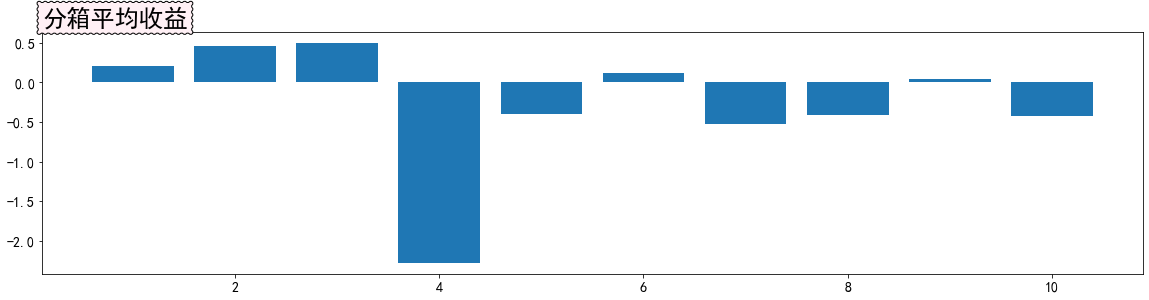

2020-11-28


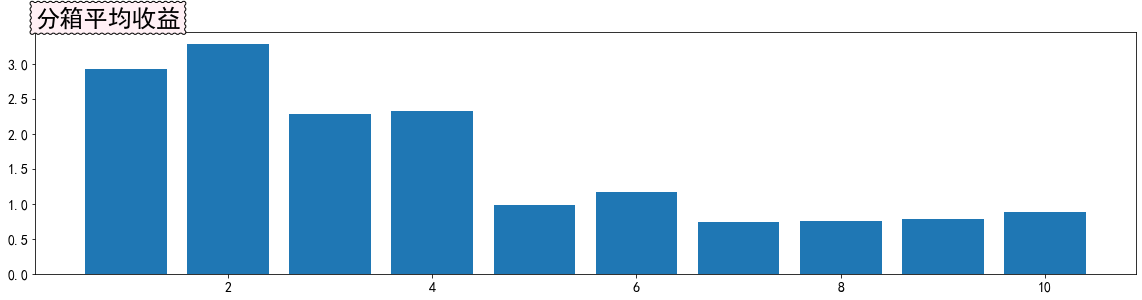

2019-11-28


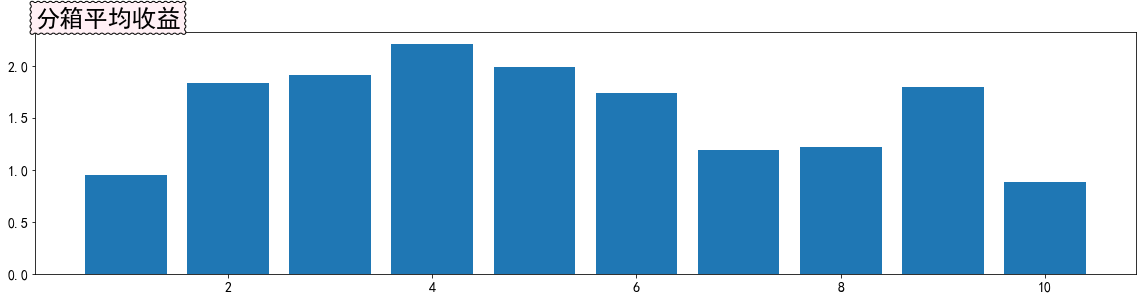

2018-11-28


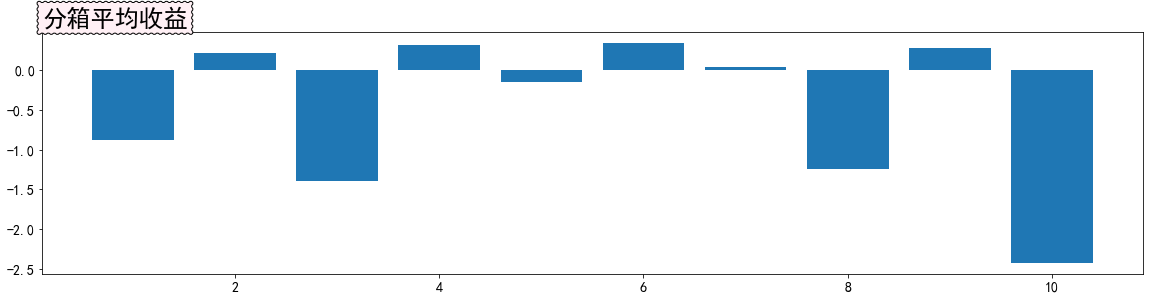

2017-11-28


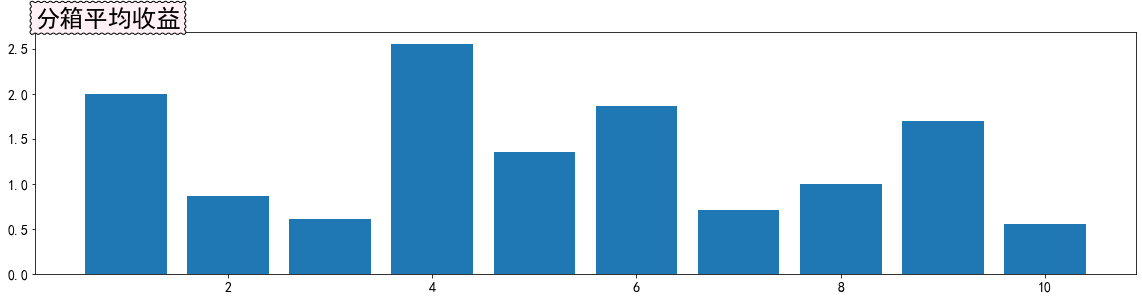

2016-11-28


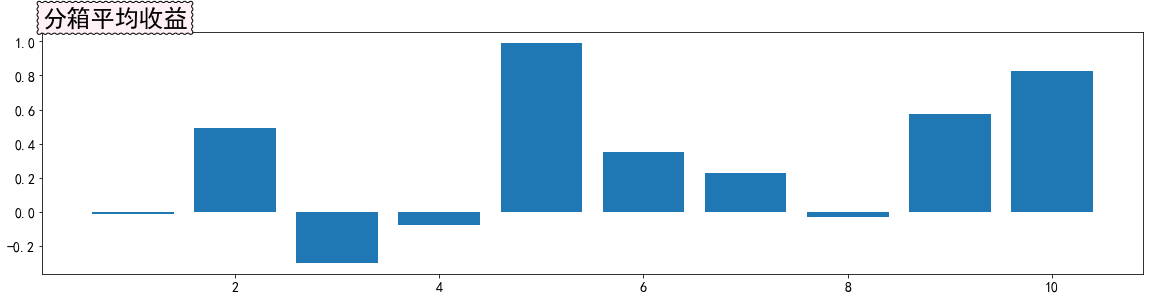

Wall time: 21.3 s


In [27]:
%%time
from tools.Test_Tools import FactorTest

%load_ext autoreload
%autoreload 1
%aimport tools.Test_Tools

dates = ['2021-11-28','2020-11-28','2019-11-28','2018-11-28','2017-11-28','2016-11-28']
# dates = ['2020-11-28']
for date in dates:
    print(date)
    test = FactorTest(WPR, sample='上证50', freq="d",end=date, gap=250, only_main=True, neutralize={'enable':False,'static_mv':False},target_field='feature_WPR_CONTINUITY_NEG_ABS')
    test.process()
    test.plot(only_binned=True)


2021-11-28


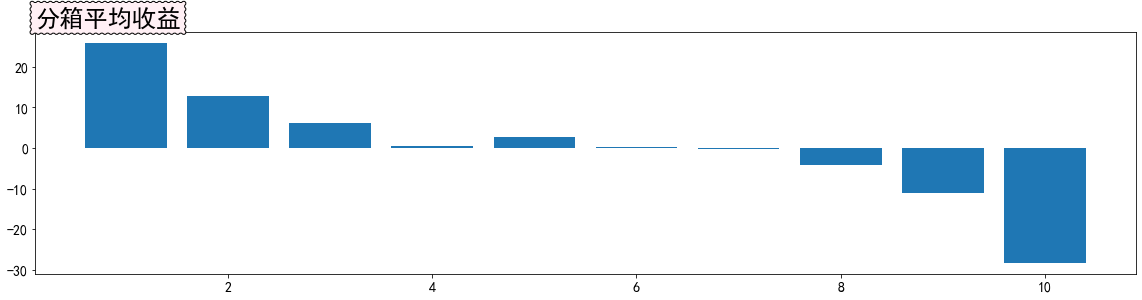

2020-11-28


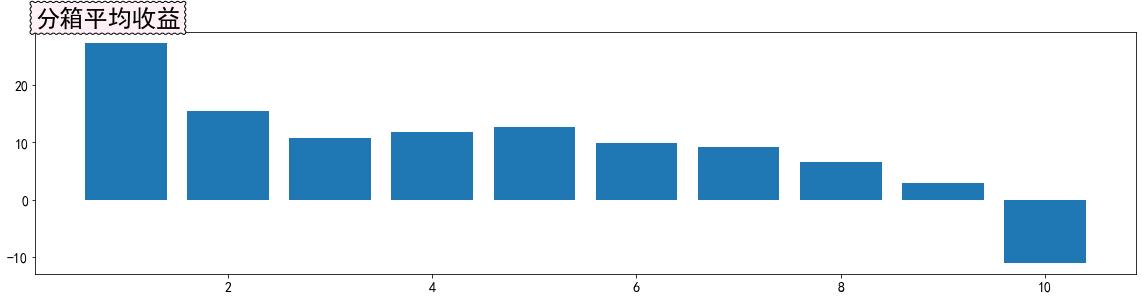

2019-11-28


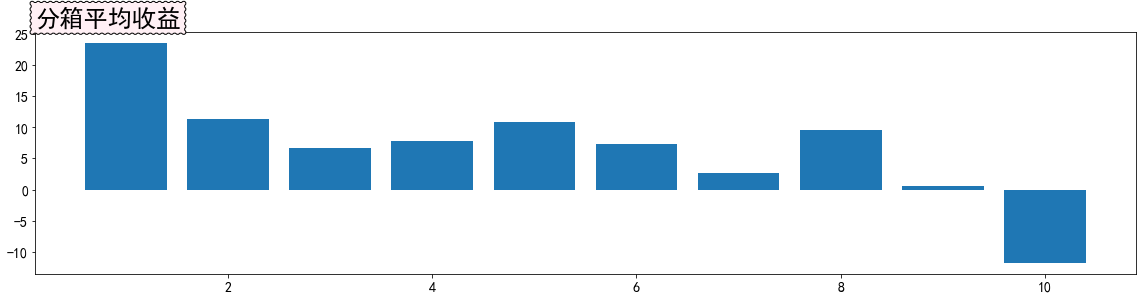

2018-11-28


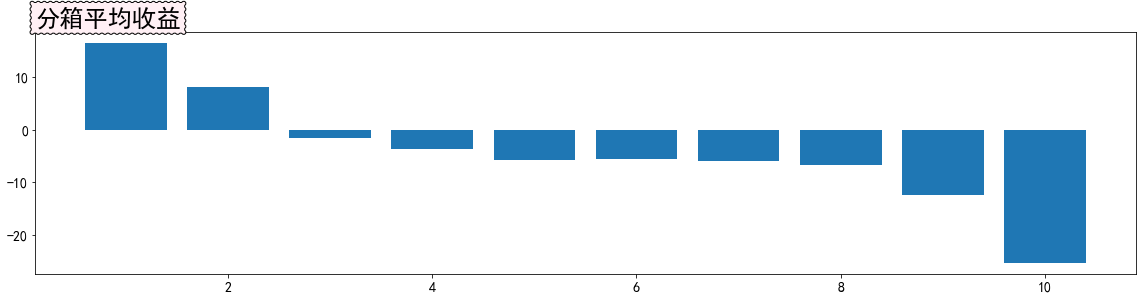

2017-11-28


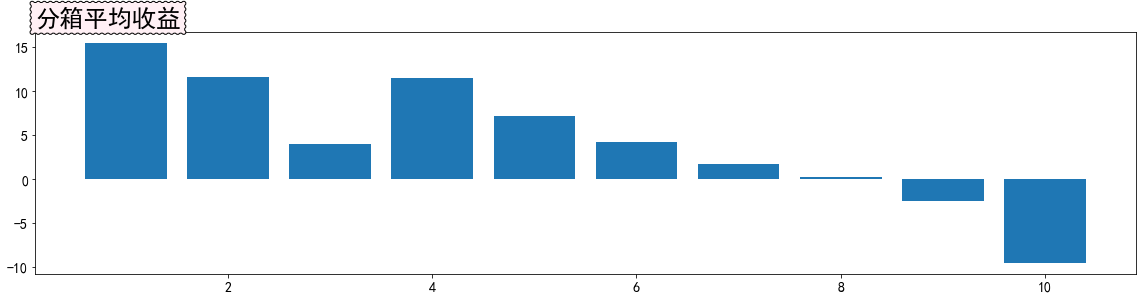

2016-11-28


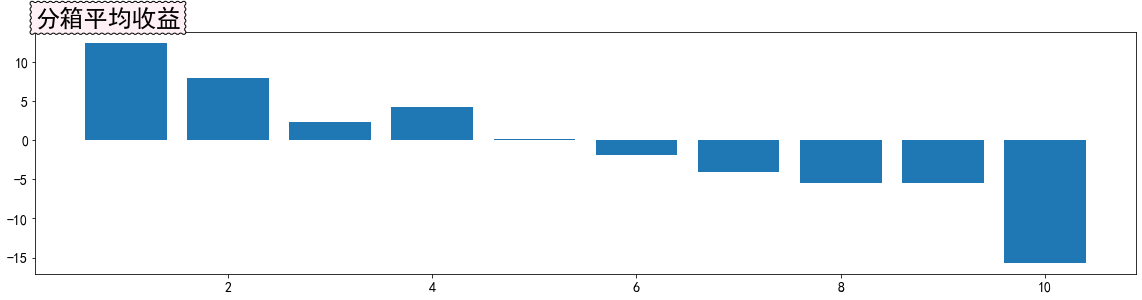

In [40]:
dates = ['2021-11-28','2020-11-28','2019-11-28','2018-11-28','2017-11-28','2016-11-28']
# dates = ['2020-11-28']
for date in dates:
    print(date)
    test = FactorTest(AD, sample='沪深300', freq="d",end=date, gap=250, only_main=True, neutralize={'enable':True,'static_mv':False},target_field='AD')
    test.process()
    test.plot(only_binned=True)

In [78]:
print(test.ind_ret_df.loc[(slice(None),'000001'),'feature_SO_CONTINUITY_NEG_ABS'].values.tolist())

[-99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, -1, 1, 2, 3, 4, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, 1, -1, 1, -1, 1, 2, -1, -2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1, -2, -3, -4, -5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, -1, -2, 1, 2, 3, -1, -2, -3, -4, -5, 1, -1, 1, 2, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, 1, -1, -2, -3, 1, -1, -2, 1, 2, -1, -2, -3, -4, -5, 1, 2, 3, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, -1, -2, -3, -4, -5, -6, -7, -8, 1, 2, 3, 4, 5, 6, 7, 8, -1, -2, -3, -4, -5, -6, -7, -8, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18]
